# Álfröðull Cloud input generator

In [1]:
import h5py

import pathlib
import re

import h5py
import imageio
import IPython.display as disp

import math
import numpy as np
import scipy

import pandas as pd

from scipy.interpolate import interp1d
from scipy.integrate import simps, quad

from astropy import constants as const
from astropy.modeling import models

from astropy import units as u

#%matplotlib ipympl
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# cloud input file from daniel

cloud_input = pathlib.Path("../input/cross_sections_mgsio3_r1mu.dat")
opacity_sample = pathlib.Path( "../input/opac_sample_r5.h5" )
cloud_sample_output = pathlib.Path( "../input/cloud_sample_r5.h5" )

# Load opacity wavelength bins

In [3]:
# get wavelength bin centers
with h5py.File(opacity_sample, "r") as opac_h5:    
                        
    # wavelength grid                
    try:
        opac_wave = [x for x in opac_h5["center wavelengths"][:]]
    except KeyError:
        opac_wave = [x for x in opac_h5["wavelengths"][:]]
        nbin = len(opac_wave)
                    
                                       
    # interface positions of the wavelength bins
    try:
        opac_interwave = [i for i in opac_h5["interface wavelengths"][:]]
    except KeyError:
        # quick and dirty way to get the lamda interface values
        opac_interwave = []
        opac_interwave.append(opac_wave[0] - (opac_wave[1] - opac_wave[0])/2)
        for x in range(len(opac_wave) - 1):
            opac_interwave.append((opac_wave[x+1] + opac_wave[x])/2)
        opac_interwave.append(opac_wave[-1] + (opac_wave[-1] - opac_wave[-2])/2)

        # widths of the wavelength bins
        try:
            opac_deltawave = [w for w in opac_h5["wavelength width of bins"][:]]
        except KeyError:
            opac_deltawave = []
            for x in range(len(opac_interwave) - 1):
                opac_deltawave.append(opac_interwave[x + 1] - opac_interwave[x])
        


In [4]:
# convert units :
opac_bin_centers_wavelengths = np.array(opac_wave)*1e-2
opac_bin_interfaces_wavelengths = np.array(opac_interwave)*1e-2

print(f"Found {len(opac_bin_centers_wavelengths)} opacity wavelength bins")
print(f"from {opac_bin_interfaces_wavelengths[0]} m to {opac_bin_interfaces_wavelengths[-1]} m ")

Found 35 opacity wavelength bins
from 3.0600000000000007e-07 m to 0.00018130233144873282 m 


# Load cloud data

In [5]:

#wavelengths (mu)
#size parameter  
#extinction cross section (cm^2)  
#scattering cross section (cm^2)  
#absorption cross section (cm^2)  
#single scattering albedo         
#asymmetry parameter  

names = [
"wavelengths",
"size_parameter",
"extinction_cross_section",
"scattering_cross_section",
"absorption_cross_section",
"single_scattering_albedo",
"asymmetry_parameter" ]

cloud_input_data = pd.read_csv(cloud_input, sep='\s+', header=None, skiprows=1, names=names)


In [6]:
# visual check of the content
cloud_input_data

,wavelengths,size_parameter,extinction_cross_section,scattering_cross_section,absorption_cross_section,single_scattering_albedo,asymmetry_parameter
0,0.30,20.943951,6.594891e-08,6.594891e-08,1.395147e-23,1.000000,0.732627
1,0.32,19.634954,7.639524e-08,7.606263e-08,3.326131e-10,0.995646,0.767291
2,0.34,18.479957,7.314272e-08,7.298440e-08,1.583142e-10,0.997836,0.743204
3,0.36,17.453293,6.224686e-08,6.215556e-08,9.130494e-11,0.998533,0.686690
4,0.38,16.534698,6.323042e-08,6.317005e-08,6.036711e-11,0.999045,0.707896
...,...,...,...,...,...,...,...
99,75.00,0.083776,6.202665e-10,1.810719e-12,6.184557e-10,0.002919,0.002369
100,80.00,0.078540,5.228403e-10,1.397746e-12,5.214426e-10,0.002673,0.002093
101,100.00,0.062832,3.274346e-10,5.668231e-13,3.268677e-10,0.001731,0.001343
102,200.00,0.031416,8.163108e-11,3.498932e-14,8.159609e-11,0.000429,0.000337


### load and convert to SI

In [7]:
cloud_wavelength = cloud_input_data['wavelengths'].values*1e-6
cloud_absorption = cloud_input_data['absorption_cross_section'].values*1e-4
cloud_scattering = cloud_input_data["scattering_cross_section"].values*1e-4

cloud_asymmetry = cloud_input_data['asymmetry_parameter'].values

print(f"Found {len(cloud_wavelength)} bins")
print(f"from {cloud_wavelength[0]} m to {cloud_wavelength[-1]} m")

Found 104 bins
from 3e-07 m to 0.0005 m


# interpolate to opacity bin centers


In [8]:
cloud_absorption_out = interp1d(cloud_wavelength, 
                                 cloud_absorption, 
                                 bounds_error=False,
                                 fill_value='extrapolate' )(opac_bin_centers_wavelengths)

cloud_scattering_out = interp1d(cloud_wavelength, 
                                 cloud_scattering, 
                                 bounds_error=False,
                                 fill_value='extrapolate' )(opac_bin_centers_wavelengths)

cloud_asymmetry_out = interp1d(cloud_wavelength, 
                                 cloud_asymmetry, 
                                 bounds_error=False,
                                 fill_value='extrapolate' )(opac_bin_centers_wavelengths)


# plots

#### check of bin repartition

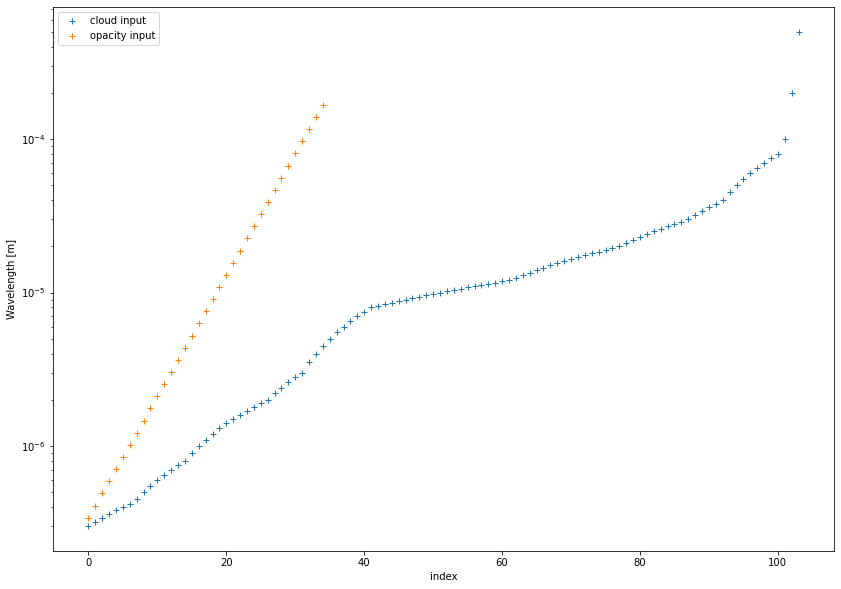

In [9]:
fig, ax_lambda = plt.subplots(1,1, figsize=(14,10))

ax_lambda.plot(cloud_wavelength, marker='+', linestyle='None', label='cloud input')
ax_lambda.plot(opac_bin_centers_wavelengths, marker='+', linestyle='None', label='opacity input')

ax_lambda.set_yscale('log')

ax_lambda.set_xlabel('index')
ax_lambda.set_ylabel('Wavelength [m]')

ax_lambda.legend();

### Absorption

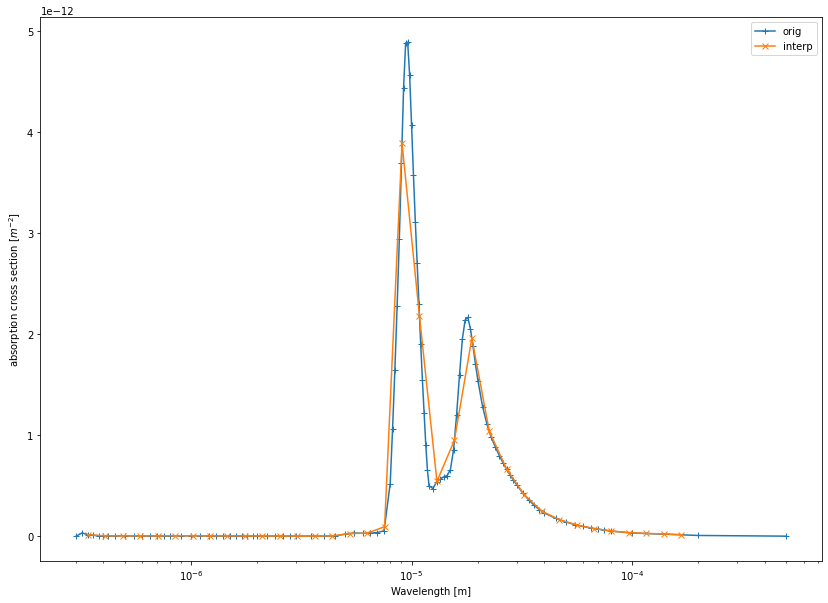

In [10]:
fig, ax_g0 = plt.subplots(1,1, figsize=(14,10))


    
ax_g0.plot(cloud_wavelength, cloud_absorption, marker='+', label='orig')
ax_g0.plot(opac_bin_centers_wavelengths, cloud_absorption_out, marker='x', label='interp')


ax_g0.set_xscale('log')
ax_g0.set_xlabel("Wavelength [m]")
ax_g0.set_ylabel("absorption cross section [$m^{-2}$]")
ax_g0.legend()
#ax.set_xlim(2e-3, 2e-2)
#ax.set_ylim(-1e10, 1e10)



### Scattering

Text(0, 0.5, 'scattering_cross_section [$m^{-2}$]')

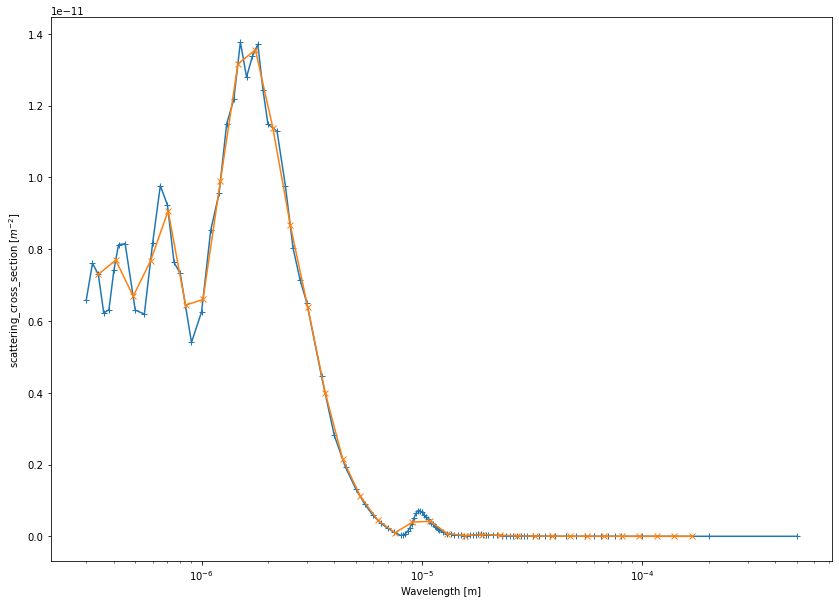

In [11]:
fig, ax_sigma_scat = plt.subplots(1,1, figsize=(14,10))

ax_sigma_scat.plot(cloud_wavelength, cloud_scattering, marker='+', label='orig')
ax_sigma_scat.plot(opac_bin_centers_wavelengths, cloud_scattering_out, marker='x', label='interp')


ax_sigma_scat.set_xscale('log')
ax_sigma_scat.set_xlabel("Wavelength [m]")
ax_sigma_scat.set_ylabel("scattering_cross_section [$m^{-2}$]")
#ax.set_xlim(2e-3, 2e-2)
#ax.set_ylim(-1e10, 1e10)

### asymmetry

Text(0, 0.5, 'asymmetry parameter')

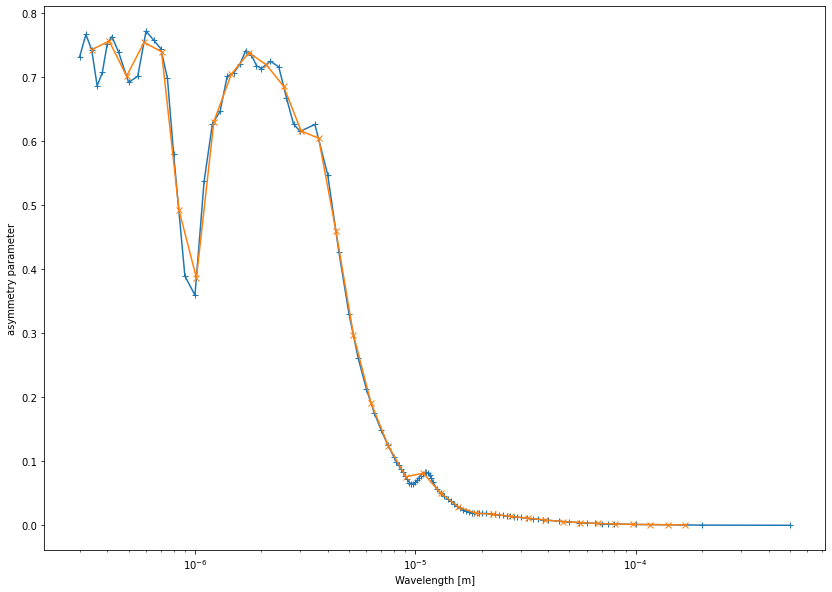

In [12]:
fig, ax_sigma_abs = plt.subplots(1,1, figsize=(14,10))

ax_sigma_abs.plot(cloud_wavelength, cloud_asymmetry, marker='+', label='orig')
ax_sigma_abs.plot(opac_bin_centers_wavelengths, cloud_asymmetry_out, marker='x', label='interp')


ax_sigma_abs.set_xscale('log')
ax_sigma_abs.set_xlabel("Wavelength [m]")
ax_sigma_abs.set_ylabel("asymmetry parameter")
#ax.set_xlim(2e-3, 2e-2)
#ax.set_ylim(-1e10, 1e10)

In [13]:
with h5py.File(cloud_sample_output, "w") as f:
    lambda_dset = f.create_dataset("wavelength", (len(opac_bin_centers_wavelengths),), dtype=np.float64)
    absorption_dset = f.create_dataset("absorption", cloud_absorption_out.shape, dtype=np.float64)
    scattering_dset = f.create_dataset("scattering", cloud_scattering_out.shape, dtype=np.float64)
    asymmetry_dset = f.create_dataset("asymmetry", cloud_asymmetry_out.shape, dtype=np.float64)
    lambda_dset[...] = opac_bin_centers_wavelengths
    absorption_dset[...] = cloud_absorption_out
    scattering_dset[...] = cloud_scattering_out
    asymmetry_dset[...] = cloud_asymmetry_out
    
    